# Customer Churn Analysis 
This notebook analyzes customer-level behavioral features to identify signals associated with churn. 

## Setup and Data Loading 

In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

pd.set_option("display.max_columns", None) 
pd.set_option("display.float_format", "{:,.2f}".format) 

In [4]:
df = pd.read_csv("../data/customer_features.csv") 

In [5]:
df.shape 

(93358, 10)

In [6]:
df.head() 

,customer_unique_id,total_orders,total_revenue,avg_order_value,first_order_ts,last_order_ts,avg_review_score,late_delivery_rate,days_since_last_order,churn_flag
0,0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,141.90,2018-05-10 10:56:27,2018-05-10 10:56:27,5.00,0.00,111,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,27.19,2018-05-07 11:11:27,2018-05-07 11:11:27,4.00,0.00,114,0
2,0000f46a3911fa3c0805444483337064,1,86.22,86.22,2017-03-10 21:05:03,2017-03-10 21:05:03,3.00,0.00,537,1
3,0000f6ccb0745a6a4b88665a16c9f078,1,43.62,43.62,2017-10-12 20:29:41,2017-10-12 20:29:41,4.00,0.00,321,1
4,0004aac84e0df4da2b147fca70cf8255,1,196.89,196.89,2017-11-14 19:45:42,2017-11-14 19:45:42,5.00,0.00,288,1


In [7]:
df.isna().sum().sort_values(ascending=False) 

avg_review_score         603
late_delivery_rate         8
total_revenue              1
avg_order_value            1
customer_unique_id         0
total_orders               0
first_order_ts             0
last_order_ts              0
days_since_last_order      0
churn_flag                 0
dtype: int64

In [5]:
df["churn_flag"] = df["churn_flag"].astype(int)
df["churn_flag"].value_counts(normalize=True) 

churn_flag
1   0.73
0   0.27
Name: proportion, dtype: float64

In [10]:
df.describe() 

,total_orders,total_revenue,avg_order_value,avg_review_score,late_delivery_rate,days_since_last_order,churn_flag
count,"93,358.00","93,357.00","93,357.00","92,755.00","93,350.00","93,358.00","93,358.00"
mean,1.03,165.95,160.32,4.15,0.08,237.48,0.73
std,0.21,227.81,219.58,1.28,0.27,152.60,0.44
min,1.00,9.59,9.59,1.00,0.00,0.00,0.00
25%,1.00,63.10,62.37,4.00,0.00,114.00,0.00
50%,1.00,107.90,105.63,5.00,0.00,218.00,1.00
75%,1.00,183.22,176.65,5.00,0.00,346.00,1.00
max,15.00,"13,664.08","13,664.08",5.00,1.00,713.00,1.00


In [7]:
metrics = [ 
    "total_orders", 
    "total_revenue", 
    "avg_order_value", 
    "avg_review_score", 
    "late_delivery_rate", 
    "days_since_last_order"
] 

churn_comparison = (
    df.groupby("churn_flag")[metrics] 
        .mean()
        .T
) 

churn_comparison.columns = ["active_customers", "churned_customers"] 
churn_comparison["difference_churned_minus_active"] = (
    churn_comparison["churned_customers"] 
    - churn_comparison["active_customers"] 
)

churn_comparison.sort_values(
    "difference_churned_minus_active", 
    ascending=False 
) 

,active_customers,churned_customers,difference_churned_minus_active
days_since_last_order,60.39,301.44,241.05
late_delivery_rate,0.06,0.09,0.03
total_orders,1.04,1.03,-0.01
avg_review_score,4.29,4.10,-0.18
avg_order_value,163.87,159.04,-4.83
total_revenue,170.07,164.46,-5.62


In [8]:
def standardized_mean_diff(df, col): 
    active = df[df["churn_flag"] == 0][col].dropna() 
    churned = df[df["churn_flag"] == 1][col].dropna() 

    pooled_std = np.sqrt((active.var(ddof=1) + churned.var(ddof=1)) /2) 

    if pooled_std == 0 or np.isnan(pooled_std): 
        return 0 

    return abs(churned.mean() - active.mean()) / pooled_std 


signals = [ 
    "total_orders", 
    "avg_order_value", 
    "total_revenue", 
    "avg_review_score", 
    "late_delivery_rate" 
] 

signal_strength = pd.Series( 
    {s: standardized_mean_diff(df, s) for s in signals} 
).sort_values(ascending=False) 

signal_strength 

avg_review_score     0.15
late_delivery_rate   0.10
total_orders         0.03
total_revenue        0.02
avg_order_value      0.02
dtype: float64

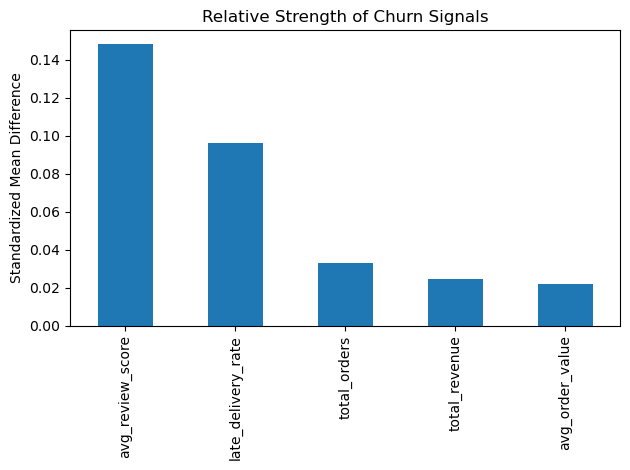

In [9]:
signal_strength.plot(kind="bar") 
plt.title("Relative Strength of Churn Signals") 
plt.ylabel("Standardized Mean Difference")
plt.tight_layout() 
plt.show() 